# Model development (Thesis)

Date: 13 October 2025<br>
By: Eunhye Yang<br>
Description: Prognosis model development for thesis

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind
import joblib

train = pd.read_csv('./preprocessing/final_preprocessed_nosurgery_thesis_train.csv')
test = pd.read_csv('./preprocessing/final_preprocessed_nosurgery_thesis_test.csv')
df = pd.concat([train, test], axis=0)

## Preprocessing

In [2]:
y_train = train['outcomes'].copy()
y_test = test['outcomes'].copy()
X_train = train.drop(['@6MmRS', '@6Mmortality', 'ICHScore', 'mICHScore', 'outcomes'], axis=1)
X_test = test.drop(['@6MmRS', '@6Mmortality', 'ICHScore', 'mICHScore', 'outcomes'], axis=1)

In [3]:
prefixes = [
    'AdmissionGCS',
    'Location0supratentorial1infratentorial',
    'EverIVH',
]
cols_to_drop = [col for col in X_train.columns if any(col.startswith(prefix) for prefix in prefixes)]

In [4]:
X_det_train = X_train.drop(columns=cols_to_drop, axis=1).copy()
X_det_test = X_test.drop(columns=cols_to_drop, axis=1).copy()

## Model initialization

In [5]:
model = RandomForestClassifier(
    n_estimators=50,
    min_samples_leaf=6,
    random_state=42
)
model.fit(X_det_train, y_train)

,n_estimators,50
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,6
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [6]:
joblib.dump(model, 'model_thesis.pkl')

['model_thesis.pkl']

## Model performance evaluation

In [7]:
y_pred = model.predict(X_det_test)
y_pred_proba = model.predict_proba(X_det_test)

In [8]:
print(classification_report(y_test, y_pred, labels=[0, 1, 2], target_names=['mRS 0-2', 'mRS 3-5', 'mRS 6']))

              precision    recall  f1-score   support

     mRS 0-2       0.84      0.85      0.85        81
     mRS 3-5       0.72      0.76      0.74        68
       mRS 6       0.91      0.79      0.85        38

    accuracy                           0.81       187
   macro avg       0.82      0.80      0.81       187
weighted avg       0.81      0.81      0.81       187



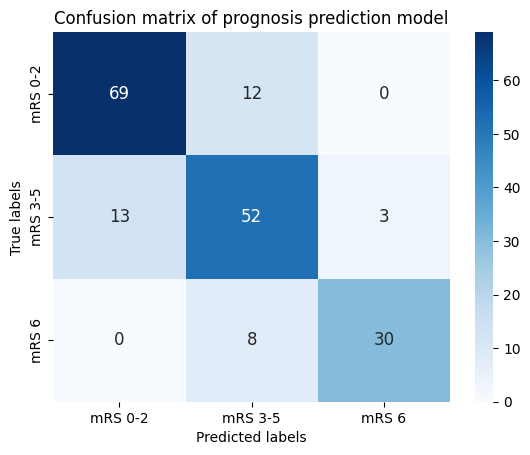

In [10]:
cm = confusion_matrix(y_test, y_pred, labels=range(len(np.unique(y_train))))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 12})
plt.title('Confusion matrix of prognosis prediction model')
plt.xlabel('Predicted labels')
plt.xticks([0.5,1.5,2.5], ['mRS 0-2', 'mRS 3-5', 'mRS 6'])
plt.ylabel('True labels')
plt.yticks([0.5,1.5,2.5], ['mRS 0-2', 'mRS 3-5', 'mRS 6'])
# plt.savefig('cm_blues.png')
plt.show()

In [12]:
y_test_proba = label_binarize(y_test, classes=[0, 1, 2])

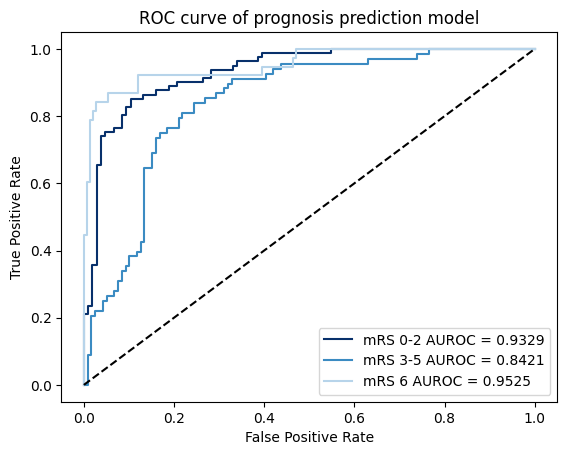

In [15]:
cmap = plt.get_cmap('Blues_r')
# cmap = plt.get_cmap('bone')
for i in range(len(np.unique(y_train))):
    auc_score = roc_auc_score(y_test_proba[:,i], y_pred_proba[:,i])
    ftemp, ttemp, thres = roc_curve(y_test_proba[:,i], y_pred_proba[:,i])
    if i == 0: label = 'mRS 0-2'
    elif i == 1: label = 'mRS 3-5'
    elif i == 2: label = 'mRS 6'
    plt.plot(ftemp, ttemp, label='%s AUROC = %0.4f' % (label, auc_score), color=cmap(i*0.35))
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC curve of prognosis prediction model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('roc_blues.png')
plt.show()

## Feature importance

In [16]:
features = [model.feature_names_in_, model.feature_importances_]

In [17]:
for i in range(len(features[0])):
    highest = features[1][i]
    for j in range(i, len(features[1])):
        if features[1][j] > highest:
            highest = features[1][j]
            temp = features[0][i]
            features[0][i] = features[0][j]
            features[0][j] = temp
            temp = features[1][i]
            features[1][i] = features[1][j]
            features[1][j] = temp

In [18]:
features[0]

array(['Age', 'Esubscore', 'LLpower', 'LARGESTICHVOLUME', 'ULpower',
       'Vsubscore', 'Msubscore', 'GRAEBSCORE', 'AdmissiondiastolicBP',
       'Admissionpulserate', 'AdmissionsystolicBP', 'CKDclass',
       'location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe2',
       'location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe1',
       'Sex0female1male', 'Laterality0L1R2Central0',
       'location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe4',
       'location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe0',
       'DM0no1yes',
       'location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe7',
       'Atrialfibirllation', 'Laterality0L1R2Central1',
       'Statin0no1Simva2Atorva3Rovu4others0',
       'Statin0no1Simva2Atorva3Rovu4others1',
       'Anticoagulant0no1warfarin2NOAC0', 'ISTIA',
       'location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe6',
       'Race0chinese1nonchinese',
       'location0tha1ICGP2LN3caudate4lobar5occipital

In [19]:
for i, val in enumerate(features[0]):
    if val == 'location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe0': features[0][i] = 'Location (thalamus)'
    if val == 'location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe1': features[0][i] = 'Location (IC/GP)'
    if val == 'location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe2': features[0][i] = 'Location (lateral nucleus)'
    if val == 'location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe3': features[0][i] = 'Location (caudate)'
    if val == 'location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe4': features[0][i] = 'Location (lobar)'
    if val == 'location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe5': features[0][i] = 'Location (occipital)'
    if val == 'location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe6': features[0][i] = 'Location (brainstem)'
    if val == 'location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe7': features[0][i] = 'Location (cerebellum)'
    if val == 'Laterality0L1R2Central0': features[0][i] = 'Laterality (left)'
    if val == 'Laterality0L1R2Central1': features[0][i] = 'Laterality (right)'
    if val == 'Laterality0L1R2Central2': features[0][i] = 'Laterality (central)'
    if val == 'Statin0no1Simva2Atorva3Rovu4others0': features[0][i] = 'Statin (None)'
    if val == 'Statin0no1Simva2Atorva3Rovu4others1': features[0][i] = 'Statin (Simvastatin)'
    if val == 'Statin0no1Simva2Atorva3Rovu4others2': features[0][i] = 'Statin (Atorvastatin)'
    if val == 'Statin0no1Simva2Atorva3Rovu4others3': features[0][i] = 'Statin (Rosuvastatin)'
    if val == 'Statin0no1Simva2Atorva3Rovu4others4': features[0][i] = 'Statin (Others)'
    if val == 'Anticoagulant0no1warfarin2NOAC0': features[0][i] = 'Anticoagulant (None)'
    if val == 'Anticoagulant0no1warfarin2NOAC1': features[0][i] = 'Anticoagulant (Warfarin)'
    if val == 'Anticoagulant0no1warfarin2NOAC2': features[0][i] = 'Anticoagulant (NOAC)'
    if val == 'ISTIA': features[0][i] = 'Transient Ischemic Attack'
    if val == 'LARGESTICHVOLUME': features[0][i] = 'Largest ICH volume'
    if val == 'Esubscore': features[0][i] = 'E subscore'
    if val == 'Vsubscore': features[0][i] = 'V subscore'
    if val == 'Msubscore': features[0][i] = 'M subscore'
    if val == 'ULpower': features[0][i] = 'Upper limb power'
    if val == 'LLpower': features[0][i] = 'Lower limb power'
    if val == 'GRAEBSCORE': features[0][i] = 'Graeb score'
    if val == 'AdmissionsystolicBP': features[0][i] = 'Admission systolic BP'
    if val == 'AdmissiondiastolicBP': features[0][i] = 'Admission diastolic BP'
    if val == 'Admissionpulserate': features[0][i] = 'Admission pulse rate'
    if val == 'CKDclass': features[0][i] = 'CKD class'
    if val == 'Sex0female1male': features[0][i] = 'Sex'
    if val == 'DM0no1yes': features[0][i] = 'Diabetes mellitus'
    if val == 'Race0chinese1nonchinese': features[0][i] = 'Race (Chinese/Non-Chinese)'

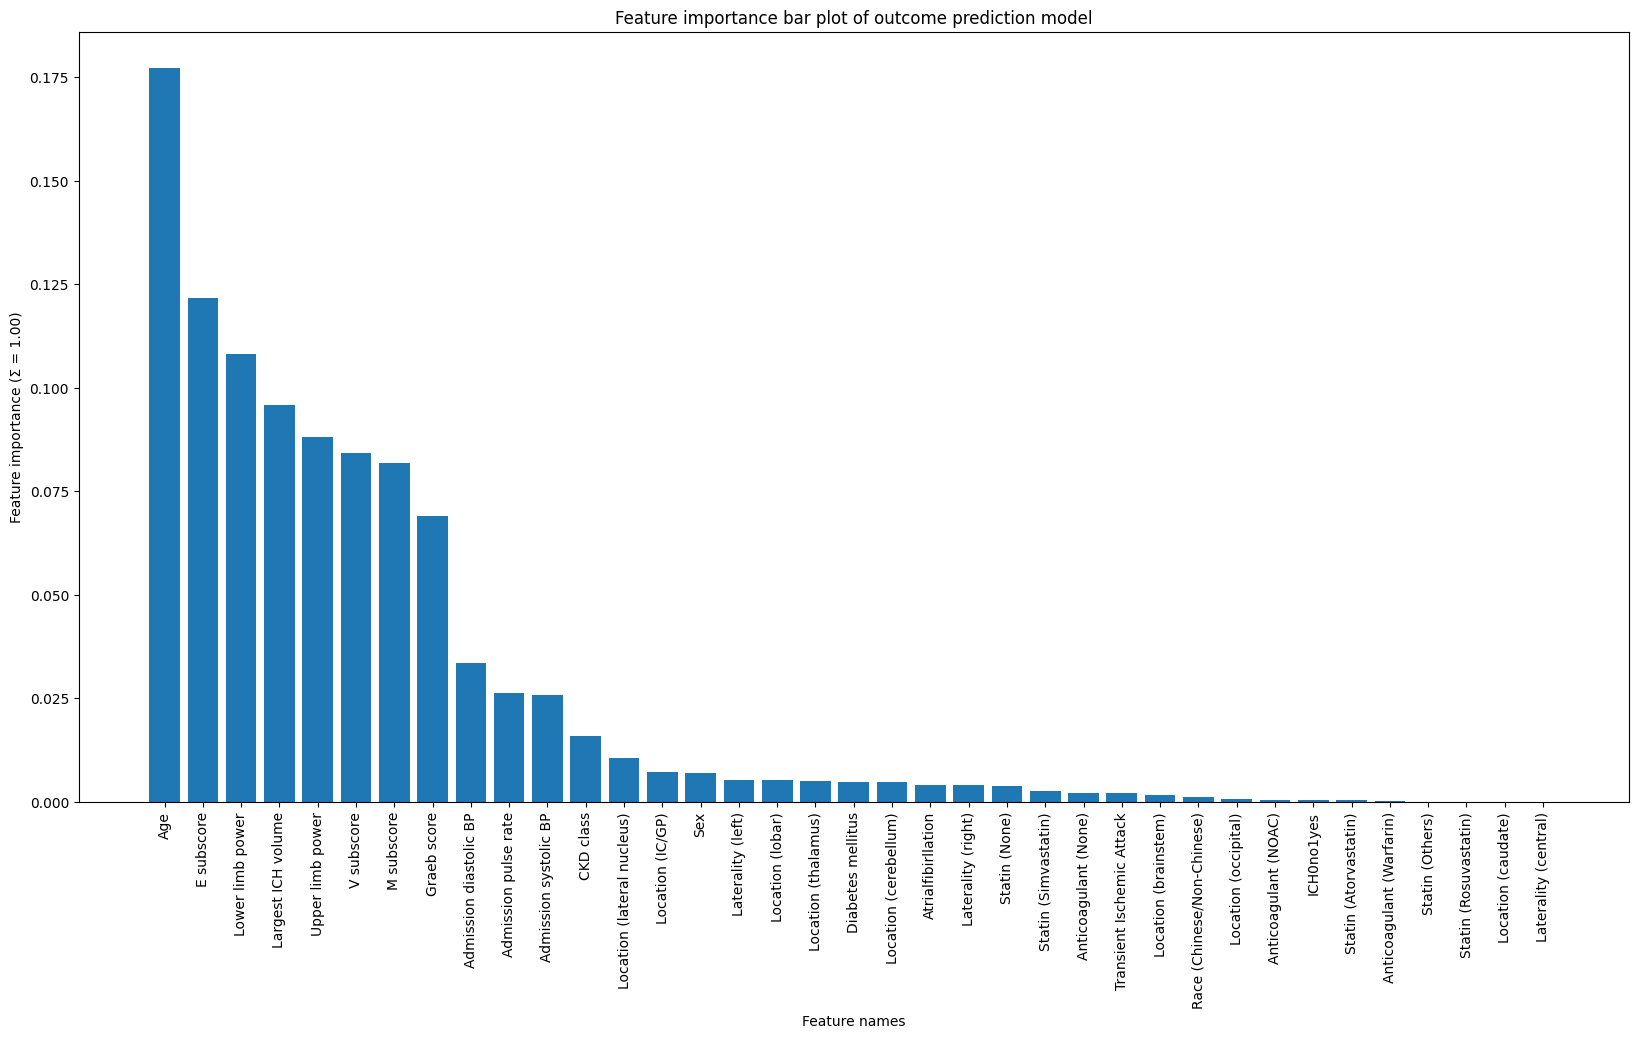

In [20]:
plt.figure(figsize=(20, 10))
plt.bar(range(len(features[1][:])), features[1][:])
plt.xticks(range(len(features[0][:])), features[0][:], rotation='vertical')
plt.xlabel('Feature names')
plt.ylabel('Feature importance (Σ = 1.00)')
plt.title('Feature importance bar plot of outcome prediction model')
plt.savefig('feature_importance.png')
plt.show()

### Top 0.9 of the feature importance

In [21]:
add = 0
for name, importance in zip(features[0], features[1]):
    add += importance
    if add > 0.9: break
    print(name, ': ', importance)

Age :  0.17709258836999353
E subscore :  0.1217466977129661
Lower limb power :  0.10801115549549795
Largest ICH volume :  0.09582657268607923
Upper limb power :  0.08797427535697383
V subscore :  0.08418417599995762
M subscore :  0.08175197257285795
Graeb score :  0.06892160501714659
Admission diastolic BP :  0.03348689423345559
Admission pulse rate :  0.026191701776034967
